In [2]:
from citrination_client.models.client import ModelsClient
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
from xrsdkit.tools.profiler import profile_spectrum, spherical_normal_profile

#### Step 1. Read q (1/A) and Intensity from csv file

In [4]:
path = 'spheres_0.csv'
q_I = np.genfromtxt (path, delimiter=",")

#### Step 2 (Optional). Examine the spectrum

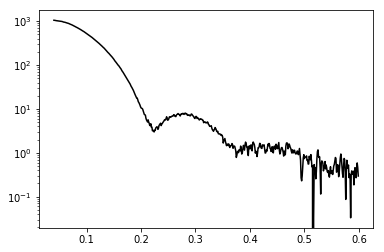

In [5]:
plt.semilogy(q_I[:,0],q_I[:,1],'-k')
plt.show()

#### Step 3. Calculate numerical features (profile) of the spectrum

In [6]:
features = profile_spectrum(q_I)
features

OrderedDict([('Imax_over_Imean', 8.4657299238804526),
             ('Imax_sharpness', 1.0088195729583314),
             ('I_fluctuation', 0.0010654446479864269),
             ('logI_fluctuation', 4.073991093725513),
             ('logI_max_over_std', 2.7630606732616809),
             ('r_fftIcentroid', 0.095911270340407126),
             ('r_fftImax', 0.0017857142857142857),
             ('q_Icentroid', 0.086251530000588189),
             ('q_logIcentroid', 0.12125127616866971),
             ('pearson_q', -0.66805497090043053),
             ('pearson_q2', -0.51903809806902934),
             ('pearson_expq', -0.62443143068244178),
             ('pearson_invexpq', 0.71088922350712547)])

We can use this set of features to predict system class. We can enter them manualy in web interface:
https://slac.citrination.com/data_views/43/predict
 
But as you can see, we have "Property" word as a part of property name. Thus, we need to add "property" for each feature name:

In [7]:
def append_str_property(sample_params):
    inputs = {}
    for k,v in sample_params.items():
        k = "Property " + k
        inputs[k] = v
    return inputs

inputs = append_str_property(features)
inputs

{'Property I_fluctuation': 0.0010654446479864269,
 'Property Imax_over_Imean': 8.4657299238804526,
 'Property Imax_sharpness': 1.0088195729583314,
 'Property logI_fluctuation': 4.073991093725513,
 'Property logI_max_over_std': 2.7630606732616809,
 'Property pearson_expq': -0.62443143068244178,
 'Property pearson_invexpq': 0.71088922350712547,
 'Property pearson_q': -0.66805497090043053,
 'Property pearson_q2': -0.51903809806902934,
 'Property q_Icentroid': 0.086251530000588189,
 'Property q_logIcentroid': 0.12125127616866971,
 'Property r_fftIcentroid': 0.095911270340407126,
 'Property r_fftImax': 0.0017857142857142857}

#### Step 4. Create SaxsCitrination using Citrination credentials

In [9]:
with open('api_key.txt', "r") as g:
    api_key = g.readline()
a_key = api_key.strip()
client = ModelsClient(webserver_host = 'https://slac.citrination.com', api_key=a_key)

#### Step 5 (optional). Get some information about a view

In [17]:
client.get_data_view('43').name # '43' is ID of  dataview

'system_classifier_f_group_meeting'

In [18]:
client.get_data_view('43').description

'System classifier using data from 4 experiments'

#### Step 5.  Predict System Class

In [19]:
result = client.predict("43", inputs) # "43" is ID of dataview on Citrination

In [20]:
result[0].get_value("system_classification").value

'pop0_diffuse__site0_spherical_normal__pop1_diffuse__site0_guinier_porod'

The model was trained using only data from 4 experiments. The data includes only 4 classes:
* pop0_unidentified, -9
* pop0_diffuse_site0_guinier_porod, -99
* pop0_diffuse_site0_spherical_normal_pop1_diffuse_site0_guinier_porod, 10
* pop0_diffuse_site0_guinier_porod_pop1_diffuse_site0_spherical_normal_pop2_fcc_site0_spherical -41

**Thus, we got the closest class. **

For some reasons this data was not used for training:
* pop0_diffuse_site0_spherical_normal_pop1_hard_spheres_site0_guinier_porod                          49
* pop0_diffuse_site0_spherical_normal                                                                  47
* pop0_hard_spheres_site0_guinier_porod                                                                26
* pop0_diffuse_site0_spherical_normal_pop1_diffuse_site0_guinier_porod_pop2_fcc_site0_spherical    16

I did not find how to get propability using new Python Client - I am going to ask Carena. 

#### Step 5. Predict r0 parameter

In [21]:
additional_features = spherical_normal_profile(q_I)
additional_features = append_str_property(additional_features)
inputs.update(additional_features)

In [22]:
result = client.predict("46", inputs) # "46" is ID of dataview on Citrination

In [23]:
result[0].get_value("Property pop0_site0_r0").value

21.02034854081824

In [24]:
result[0].get_value("Property pop0_site0_r0").loss

1.222152674654835

The Citrination models predict the mean sphere size to be 21.02 +/- 1.22  Angstrom.